A popular and useful AB-testing online course (https://www.udacity.com/course/ab-testing--ud979) is provided by Google on Udacity. I decided to use the final project topic of this course to be my python course's final project. A complete description of the final project can be found here: https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True


#### Project Introduction
The project is an A/B Testing practice. It is an experiment conducted by Udacity, an e-learning platform, with the overall business goal of maximizing course completion by students.

More specifically, an experimental step would be added after the “Start Free Trial” button on the course page. Based on this experiment, after clicking on the “Start Free Trial” button, a message would be shown asking users the weekly time that they want to invest on the course. If the input hours is below 5 hours per week, “a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggestiong that the student might like to access the course materials for free.”

The goal of this AB testing experiment is to reduce the number of students who may quit the course during the first two weeks, while leaving the number of students who pass this 14-days mark intact

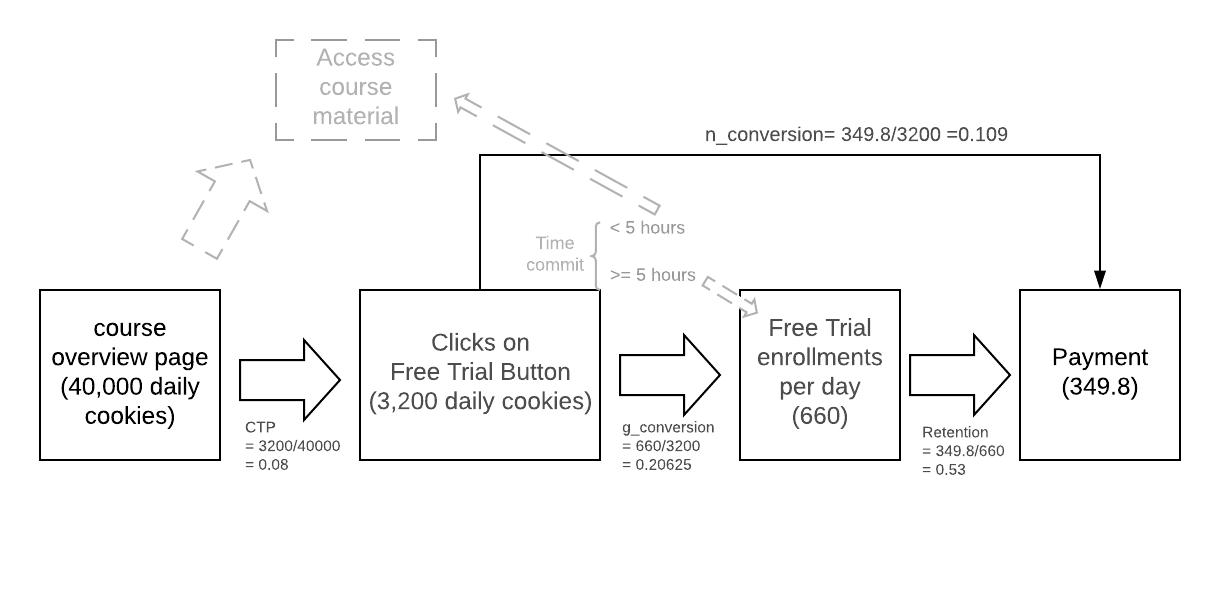

#### STEP 1. Metric Choice : Which of the following metrics should be chose to measure for this experiment and why? 
There are two kind of metrics that measure how the experiment group is better than control. These are invariance metrics and evaluation merics.

1. Invariance metrics is performing some kind of sanity check for us before running the experiment, like checking whether the distribution is the same. It performing some consistent checking across all of our experiments, which is why it shouldn't be changed. Otherwise we have to start it all over again. Some changed because we want to increase number of users involved. We would expect similiar distribution into control and experiment for the invariance metrics. Basically, this means we pick metrics which we consider not to change (not to be affected) because of our experiment and later make sure these metrics don't change drastically between our control and experiment groups.

As a result, the below three metrics are invariance metrics:
* Number of Cookies: The number of unique cookies to visit the course overview page. This is the unit of diversion and even distribution amongst the control and experiment groups is expected. It is therefore appropriate as an invariant metric.

* Number of Clicks: The number of users (tracked as unique cookies at this stage) to click the free trial buttion. This is appropriate as an invariant metric but not an evaluation metrice. Equal distribution amongst the experiment and control groups would be expected since at this point in the funnel the experience is the same for all users and therefore elements of the experiment would not be expected to impact clicking the "start free trial" button.

* Click-through-probability: Unique cookies to click the "start free trial" button per unique cookies to view the course overview page. Equal distribution amongst the experiment and control groups would be expected since at this point in the funnel the experience is the same for all users and therefore elements of the experiment would not be expected to impact clicking the "start free trial" button.


2. Evaluation metrics, is usually the business metris, like for example market share, number of users, or user experience metrics. Sometime it measure what previously stated as taking long time because it doesn't contain enough information, like measure user that got a job after taking MOOC. We would expect to see a change, and are relevant to the business goals we aim to achieve. For each metric we state a  Dmin  - which marks the minimum change which is practically significant to the business. For instance, stating that any increase in retention that is under 2%, even if statistically significant, is not practical to the business.

As a result, the below three metrics are evaluation metrics:

* Gross Conversion: This is the number of user-ids to complete checkout and enroll in the free trial per unique cookie to click the "start free trial" button. dmin = 0.01

* Retention: This is the number of user-ids to remain enrolled past the 14 day trial period, making at least one payment, per number of user-ids to complete checkout. The practical minimum difference (dmin) = 0.01

* Net Conversion: this is the number of user-ids to remain enrolled past the 14 day trial, making at least one payment, per the number of unique cookies to click the "start free trial" button. dmin = 0.0075



#### STEP 2. Measure of Variability: For each metric you selected as an evaluation metric, estimate its standard deviation analytically. Do you expect the analytic estimates to be accurate? That is, for which metrics, if any, would you want to collect an empirical estimate of the variability if you had time?

In [1]:
import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
# According to project's instructions, baseline for each metric is as below
# Baseline result is the results you’re currently getting, you want to know if the test function is doing 
# better than your current results. 
df_baselines = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS521/Final Project/baseline_vals.csv',index_col=False,header = None, names = ['metric','baseline_val'])
df_baselines

,metric,baseline_val
0,Unique cookies to view page per day:,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [3]:
metric = ['cookies','clicks','enrollments','CTP','g_conversion','retention','n_conversion']

description = df_baselines['metric']
description = [x[:-1] for x in description]

baseline_val = df_baselines['baseline_val']

d_min= [3000,240,50,0.01,0.01,0.01,0.0075]

data = {'metric':metric,'description':description,'baseline_val':baseline_val,'d_min':d_min}
metrics_df = pd.DataFrame(data)
metrics_df 


,metric,description,baseline_val,d_min
0,cookies,Unique cookies to view page per day,40000.000000,3000.0000
1,clicks,"Unique cookies to click ""Start free trial"" per...",3200.000000,240.0000
2,enrollments,Enrollments per day,660.000000,50.0000
3,CTP,"Click-through-probability on ""Start free trial""",0.080000,0.0100
4,g_conversion,"Probability of enrolling, given click",0.206250,0.0100
5,retention,"Probability of payment, given enroll",0.530000,0.0100
6,n_conversion,"Probability of payment, given clic",0.109313,0.0075


- The more variant a metric is , the harder it is to reach a significant level. As a result, before we do the significant test (calculate the required sample size and confidence intervals), we need to calcualate the standard deviation of a metric. 

- According to the project instruction, the course overview page per day = 5000

- For all the calculations to follow we need to scale our collected counts estimates of metrics with the sample size we specified for variance estimation. In this case, from 40000 (unique cookies) to 5000 (cookies visiting the course overview page per day). 

- The sample size we are considering should be smaller than the "population" we collected and small enough to have two groups with that size. Since the daily unique cookies of the overview page is 5000, we need to figure out sample size for each metric. The sample size is equal to the denominator quantity, assuming 5000 unique cookies for the overview page.

In [4]:
#Scale The counts estimates

daily_pageviews = 5000
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660,"CTP":0.08,"GConversion":0.20625,
           "Retention":0.53,"NConversion":0.109313}
scaling_ratio = daily_pageviews /baseline["Cookies"]

baseline["Cookies"] = baseline["Cookies"]* scaling_ratio
baseline["Clicks"]=baseline["Clicks"]* scaling_ratio
baseline["Enrollments"]=baseline["Enrollments"]* scaling_ratio

scaled_value = list(baseline.values())

scaled_value

metrics_df['scaled_val']= scaled_value
metrics_df

,metric,description,baseline_val,d_min,scaled_val
0,cookies,Unique cookies to view page per day,40000.000000,3000.0000,5000.000000
1,clicks,"Unique cookies to click ""Start free trial"" per...",3200.000000,240.0000,400.000000
2,enrollments,Enrollments per day,660.000000,50.0000,82.500000
3,CTP,"Click-through-probability on ""Start free trial""",0.080000,0.0100,0.080000
4,g_conversion,"Probability of enrolling, given click",0.206250,0.0100,0.206250
5,retention,"Probability of payment, given enroll",0.530000,0.0100,0.530000
6,n_conversion,"Probability of payment, given clic",0.109313,0.0075,0.109313


Estimating Analytically: In order to estimate variance analytically, we can assume metrics, which are probabilities (p̂), are binomially distributed, so we can use this formula for the standard deviation: 
- sqrt(p̂ *(1-p̂)/n)

For each metric, we need to plug two variables into the formula: 
- p̂ - baseline probability of the event to occur 
- n - sample size 

In [5]:
# Gross Conversion (GC) 
GC={}
GC["d_min"]=0.01
GC["p"]=baseline["GConversion"]
GC["n"]=baseline["Clicks"]
GC["sd"]=round(mt.sqrt((GC["p"]*(1-GC["p"]))/GC["n"]),4)
GC["sd"]

0.0202

In [6]:
# Retention(R)
R={}
R["d_min"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]
R["sd"]=round(mt.sqrt((R["p"]*(1-R["p"]))/R["n"]),4)
R["sd"]

0.0549

In [7]:
# Net Conversion (NC)
NC={}
NC["d_min"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=round(mt.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),4)
NC["sd"]

0.0156

#### STEP 3. Sizing : Choosing Number of Samples given Power -> Using the analytic estimates of variance, how many pageviews total (across both groups) would you need to collect to adequately power the experiment? Use an alpha of 0.05 and a beta of 0.2. Make sure you have enough power for each metric.

The minimum sample size for control and experiment groups, which provides probability of Type I Error  α , Power  1−β , detectable effect d  and baseline rate  p  
- simple hypothesis  H0:Pcont−Pexp=0   
- simple alternative  HA:Pcont−Pexp=d  

n=pow((z_score(1-alpha/2)*sd1+z_score(1-beta)*sd2),2)/pow(d,2)

    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    
sd1 and sd2 : for both the baseline and for expected changed rate 

In [8]:
#Inputs: required alpha value 
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs p-baseline conversion rate which is our estimated p and d-minimum detectable change
# Returns
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# Inputs:sd1 for the baseline,sd2 for the expected change,alpha,beta,d-d_min,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

In [9]:
# Gross Conversion (GC)
GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d_min"]),0.05,0.2,GC["d_min"])) 
GC["SampSize"]=round(GC["SampSize"]/0.08*2)
GC["SampSize"]

645875.0

In [10]:
# Retention(R)
R["SampSize"]=round(get_sampSize(get_sds(R["p"],R["d_min"]),0.05,0.2,R["d_min"])) 
R["SampSize"]=R["SampSize"]/0.08/0.20625*2
R["SampSize"]=round(R["SampSize"],2)
R["SampSize"]

4737818.18

In [11]:
# Net Conversion (NC)
NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d_min"]),0.05,0.2,NC["d_min"]))
NC["SampSize"]=NC["SampSize"]/0.08*2
NC["SampSize"]=round(NC["SampSize"],2)
NC["SampSize"]

685325.0

In [12]:
required_weeks = round(685325 / 40000 / 0.8 / 7 ,1)
required_weeks

3.1

##### Conclusion: 
Among these three required size of cookies, 685,325 is the biggest, so this will be our number. Assuming we take 80% of each days pageviews, the data collection period for this experiment (the period in which the experiment is revealed) will be about 3 weeks.

#### Read Data
The meaning of each column is:
- Pageviews: Number of unique cookies to view the course overview page that day.
- Clicks: Number of unique cookies to click the course overview page that day.
- Enrollments: Number of user-ids to enroll in the free trial that day.
- Payments: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

In [13]:
df_control=pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS521/Final Project/control_data.csv')
df_experiment=pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS521/Final Project/experiment_data.csv')

In [14]:
df_control

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


In [15]:
df_experiment

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
5,"Thu, Oct 16",9500,788,129.0,61.0
6,"Fri, Oct 17",9088,780,127.0,44.0
7,"Sat, Oct 18",7664,652,94.0,62.0
8,"Sun, Oct 19",8434,697,120.0,77.0
9,"Mon, Oct 20",10496,860,153.0,98.0


#### STEP4 Sanity Checks

We have 3 Invariant metrics:
- (1) Number of Cookies in Course Overview Page (pageviews/cookies)
- (2) Number of Clicks on Free Trial Button (clicks)
- (3) Free Trial button Click-Through-Probability (CTP)
-------------------------------------------------------------------------------------------------------------
- Start by checking whether your invariant metrics are equivalent between the two groups. If the invariant metric is a simple count that should be randomly split between the 2 groups, you can use a binomial test. 
- Otherwise, you will need to construct a confidence interval for a difference in proportions, then check whether the difference between group values falls within that confidence level.
- If your sanity checks fail, look at the day by day data and see if you can offer any insight into what is causing the problem.

##### Binomial test & Confidence interval:
We expect the amount of pageviews in the control group to be about a half (50%) of the total pageviews in both groups, so we can define a random variable with an easy to use distribution. 
A binomial random variable will be the number of successes we can expect to get out of N experiments, given the probability of a single success. So, if we consider being assigned to a group (control, for example) a success with probability 0.5 (random!), the number of samples which get assigned to the group is the value of our random binomial variable! 

According to central limit theorem, we can approximate the binomial distribution to a normal distribution (when n is large enough) with a mean of  p  and a standard deviation sqrt(p(1-p)/n)

What we want to test is whether our observed  p̂   (number of samples in control divided by total number of samples in both groups) is not significantly different than  p=0.5 . In order to do that we can calculate the margin of error acceptable at a 95% confidence level:

In [16]:
# pageviews
pageviews_cont=df_control['Pageviews'].sum()
pageviews_exp=df_experiment['Pageviews'].sum()
pageviews_total=pageviews_cont+pageviews_exp
print ("number of pageviews in control:", pageviews_cont)
print ("number of Pageviews in experiment:" ,pageviews_exp)

p=0.5
alpha=0.05
pageviews_p_hat=round(pageviews_cont/(pageviews_total),4)
sd=mt.sqrt(p*(1-p)/(pageviews_total))
ME=round(get_z_score(1-(alpha/2))*sd,4) #marginal error
print("pageviews_p_hat = ", pageviews_p_hat)
print ("The confidence interval of pageviews_p is between",p-ME,"and",p+ME)


# clicks
clicks_cont=df_control['Clicks'].sum()
clicks_exp=df_experiment['Clicks'].sum()
clicks_total=clicks_cont+clicks_exp
print ("\nnumber of clicks in control:", clicks_cont)
print ("number of clicks in experiment:" ,clicks_exp)


clicks_p_hat=round(clicks_cont/(clicks_total),4)
sd=mt.sqrt(p*(1-p)/(clicks_total))
ME=round(get_z_score(1-(alpha/2))*sd,4) #marginal error
print("clicks_p_hat = ", pageviews_p_hat)
print ("The confidence interval of clicks_p is between",p-ME,"and",p+ME)


number of pageviews in control: 345543
number of Pageviews in experiment: 344660
pageviews_p_hat =  0.5006
The confidence interval of pageviews_p is between 0.4988 and 0.5012

number of clicks in control: 28378
number of clicks in experiment: 28325
clicks_p_hat =  0.5006
The confidence interval of clicks_p is between 0.4959 and 0.5041


##### pooled standard error
A pooled standard error accounts for two sample variances and assumes that both of the variances from the two samples are equal. It’s called a “pooled” standard error because you’re pooling the data from both samples into one. The formula for the pooled sample standard error is:
- p_pooled=(X_cont+X_exp)/ (N_cont + N_exp)
- sd_pooled= sqrt(p_pooled*(1-p_pooled)*(1/N_cont +1/N_exp))


In [17]:
CTP_cont=clicks_cont/pageviews_cont
CTP_exp=clicks_exp/pageviews_exp
d_hat=round(CTP_exp-CTP_cont,4) # difference between control group and experimental group
p_pooled=clicks_total/pageviews_total
sd_pooled=mt.sqrt(p_pooled*(1-p_pooled)*(1/pageviews_cont+1/pageviews_exp))
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print("d_hat = ", d_hat)
print ("The confidence interval of d is between",0-ME,"and",0+ME)

d_hat =  0.0001
The confidence interval of d is between -0.0013 and 0.0013


##### Conclusion:
We pass all the sanity checks

#### STEP5. Check for Practical and Statistical Significance
Next, for your evaluation metrics, calculate a confidence interval for the difference between the experiment and control groups, and check whether each metric is statistically and/or practically significance. A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)

If you have chosen multiple evaluation metrics, you will need to decide whether to use the Bonferroni correction. When deciding, keep in mind the results you are looking for in order to launch the experiment. Will the fact that you have multiple metrics make those results more likely to occur by chance than the alpha level of 0.05?

In this stage, we want to assess whether the differences between evaluation metric (g_conversion and n_conversion) values of the control and experiment groups are significant or not.

- H0: There is no difference in evaluation metric between control and experiment groups
- H1: There is significant difference in evaluation metric between control and experiment groups

In [18]:
# Count the total clicks from complete records only
clicks_cont=df_control["Clicks"].loc[df_control["Enrollments"].notnull()].sum()
clicks_exp=df_experiment["Clicks"].loc[df_experiment["Enrollments"].notnull()].sum()

#Gross Conversion - number of enrollments divided by number of clicks
enrollments_cont=df_control["Enrollments"].sum()
enrollments_exp=df_experiment["Enrollments"].sum()

GC_cont=enrollments_cont/clicks_cont
GC_exp=enrollments_exp/clicks_exp
GC_pooled=(enrollments_cont+enrollments_exp)/(clicks_cont+clicks_exp)
GC_sd_pooled=mt.sqrt(GC_pooled*(1-GC_pooled)*(1/clicks_cont+1/clicks_exp))
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4)
GC_diff=round(GC_exp-GC_cont,4)
print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to the experiment is -2.06 %
Confidence Interval: [ -0.0292 , -0.012 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


In [19]:
#Net Conversion - number of payments divided by number of clicks
payments_cont=df_control["Payments"].sum()
payments_exp=df_experiment["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(get_z_score(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff*100,"%")
print("Confidence Interval: [",NC_diff-NC_ME,",",NC_diff+NC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",NC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.49 %
Confidence Interval: [ -0.0116 , 0.0018000000000000004 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if 0.0075 is not in the CI as well.


#### Summary: 
- The requirement for launching the experiment is that the null hypothesis must be rejected for ALL evaluation metrics and that the difference between branches must meet or exceed the practical signficance threshold. 
- Analysis revealed the expected equal distribution of cookies into the control and experimental groups, for the invariant metrics, at the 95% CI. A difference in gross conversion was found to be statistically signficant at the 95% CI, and the null hypothesis was rejected. Gross conversion also met the practical signficance threshold. Net Conversion was found to be neither statistically nor practically signficant at the 95% CI.

#### Recommendation:
- This experiment was designed to determine whether filtering students as a function of study time commitment would improve the overall student experience and the coaches' capacity to support students who are likely to complete the course, without significantly reducing the number of students who continue past the free trial. 

- A statistically and practically signficant decrease in Gross Conversion was observed but with no significant differences in Net Conversion. This translates to a decrease in enrollment not coupled to an increase in students staying for the requisite 14 days to trigger payment. 

- Considering above test results and the expected outcome of this new function (to increase fraction of paying users by asking them in advance if they have the time to invest in the course),I would recomend not to launch this new function, but rather to pursue other experiments.


#### Reference:
- https://tw.saowen.com/a/085a75919aa5d649fe1e3d717af95a0f6bc802d311e6d5dae43ff141672a1355
- https://www.kaggle.com/tammyrotem/ab-tests-with-python/notebook
- https://rpubs.com/Shaahin/ab-test-udacity
- https://github.com/baumanab/udacity_ABTesting#summary
- https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True
- https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
- https://www.crazyegg.com/blog/ab-testing-6-steps/
- http://ethen8181.github.io/Business-Analytics/ab_tests/frequentist_ab_test.html
- http://napitupulu-jon.appspot.com/posts/metrics-abtesting-udacity.html